## **Problem:**

An agricultural management agency needs to conduct a rapid assessment of land cover status in a vulnerable region following an extreme weather event (e.g., drought or flooding). They lack up-to-date baseline data for the area but have access to thousands of high-resolution satellite images of the region.

The goal is to use cluster analysis to group these images into categories (clusters) representing different land cover types (e.g., healthy cropland, dense forest, bare soil, flooded area). It is hypothesized that clusters representing "bare soil," "industrial area," or "stagnant water" are indicators of damaged or at-risk agroecological zones.

https://www.kaggle.com/datasets/apollo2506/eurosat-dataset

In [1]:
!pip install rich

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import seaborn as sns
from yellowbrick.cluster import silhouette_visualizer, KElbowVisualizer
from PIL import Image
from rich.console import Console
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture

console = Console()

## **Donwload Data**

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("apollo2506/eurosat-dataset")

console.print("Path to dataset files:", path)

Using Colab cache for faster access to the 'eurosat-dataset' dataset.


Path to dataset files: /kaggle/input/eurosat-dataset

In [4]:
!ls {path}/EuroSAT/

AnnualCrop	      Highway	      Pasture	     River     train.csv
Forest		      Industrial      PermanentCrop  SeaLake   validation.csv
HerbaceousVegetation  label_map.json  Residential    test.csv


In [5]:
from torch import e
from genericpath import isdir
import os

eurosat_classes = {
    "AnnualCrop": 0,
    'Forest': 1,
    'HerbaceousVegetation': 2,
    'Highway': 3,
    'Industrial': 4,
    'Pasture': 5,
    'PermanentCrop': 6,
    'Residential': 7,
    'River': 8,
    'SeaLake': 9,
}

all_images = []
all_images_y = []

for directory in os.listdir(path + "/EuroSAT/"):
  if os.path.isdir(path + "/EuroSAT/" + directory):
    y = -1
    console.print(f"Directory: {directory}")
    match directory:
      case "AnnualCrop":
        y = eurosat_classes["AnnualCrop"]
      case "Forest":
        y = eurosat_classes["Forest"]
      case "HerbaceousVegetation":
        y = eurosat_classes["HerbaceousVegetation"]
      case "Highway":
        y = eurosat_classes["Highway"]
      case "Industrial":
        y = eurosat_classes["Industrial"]
      case "Pasture":
        y = eurosat_classes["Pasture"]
      case "PermanentCrop":
        y = eurosat_classes["PermanentCrop"]
      case "Residential":
        y = eurosat_classes["Residential"]
      case "River":
        y = eurosat_classes["River"]
      case "SeaLake":
        y = eurosat_classes["SeaLake"]
    console.print(f"y: {y}")
    directory_images = []

    for file in os.listdir(path + "/EuroSAT/" + directory):
      all_images.append(path + "/EuroSAT/" + directory + "/" + file)
      directory_images.append(path + "/EuroSAT/" + directory + "/" + file)

    console.print(f"Number of images in directory: {len(directory_images)}")
    all_images_y.append({"images":directory_images, "y": y})

console.print(f"Total Number of images: {len(all_images)}")

Directory: SeaLake

y: 9

Number of images in directory: 3000

Directory: Highway

y: 3

Number of images in directory: 2500

Directory: River

y: 8

Number of images in directory: 2500

Directory: Pasture

y: 5

Number of images in directory: 2000

Directory: Industrial

y: 4

Number of images in directory: 2500

Directory: Residential

y: 7

Number of images in directory: 3000

Directory: PermanentCrop

y: 6

Number of images in directory: 2500

Directory: AnnualCrop

y: 0

Number of images in directory: 3000

Directory: Forest

y: 1

Number of images in directory: 3000

Directory: HerbaceousVegetation

y: 2

Number of images in directory: 3000

Total Number of images: 27000

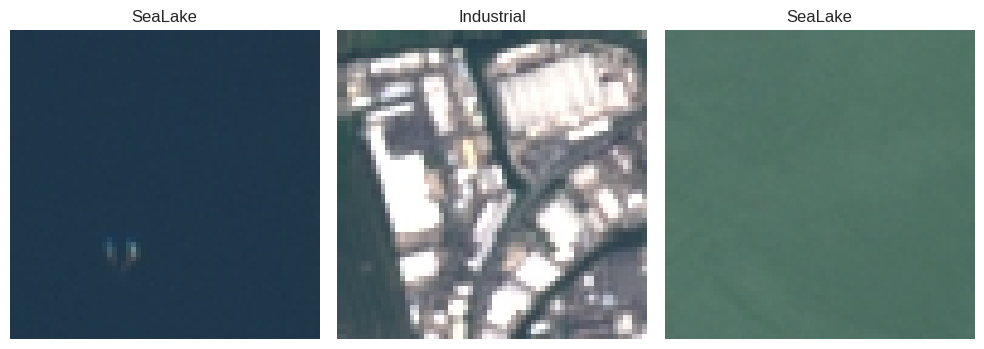

In [6]:
sample_images = random.sample(all_images, 3)

plt.figure(figsize=(10, 5))
for i, img_path in enumerate(sample_images):
    img = Image.open(img_path)
    plt.subplot(1, 3, i + 1)
    plt.imshow(img)
    plt.title(img_path.split('/')[-2])
    plt.axis('off')
plt.tight_layout()
plt.show()

## **Clustering**

In [7]:
image_data = []
for img_path in all_images:
    img = Image.open(img_path)
    img_array = np.array(img)
    img_flattened = img_array.flatten()
    image_data.append(img_flattened)

X = np.array(image_data)
X_scaled = X / 255.0

console.print(f"Shape of processed image data (X_scaled): {X_scaled.shape}")

Shape of processed image data (X_scaled): (27000, 12288)

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2000)
pca.fit(X_scaled)

explained_variance_ratio = pca.explained_variance_ratio_
console.print(f"Shape of explained variance ratio: {explained_variance_ratio.shape}")

Shape of explained variance ratio: (2000,)

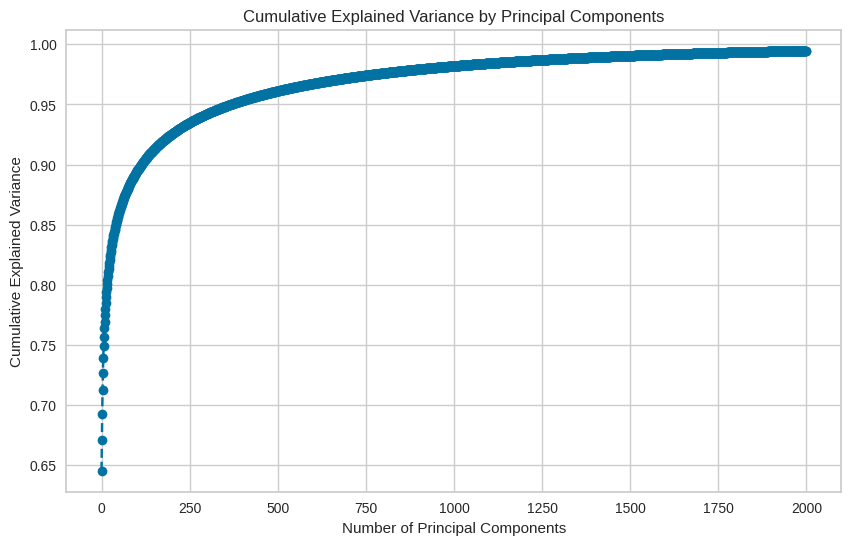

In [9]:
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(10, 6))
plt.plot(cumulative_explained_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

In [10]:
eigenvalues = pca.explained_variance_
console.print(f"Number of components found: {len(eigenvalues)}")
console.print("\nEigenvalues (variance explained by each component):\n")

eigenvalue_df = pd.DataFrame({
    'Principal Component': range(1, len(eigenvalues) + 1),
    'Eigenvalue': eigenvalues
})
display(eigenvalue_df.head(25))

Number of components found: 2000

Eigenvalues (variance explained by each component):

,Principal Component,Eigenvalue
0,1,193.402798
1,2,7.555874
2,3,6.533203
3,4,6.078189
4,5,4.112185
5,6,3.807666
6,7,2.912846
7,8,2.285012
8,9,2.196748
9,10,1.657171


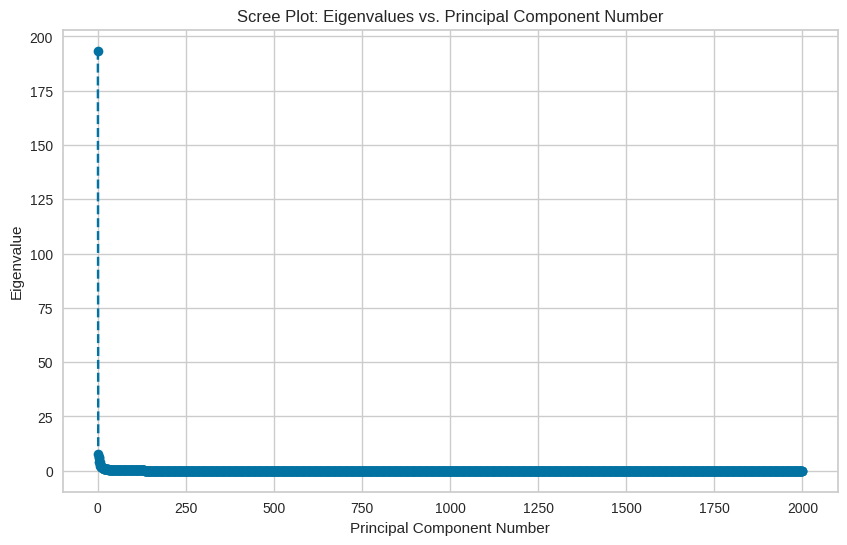

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, marker='o', linestyle='--')
plt.title('Scree Plot: Eigenvalues vs. Principal Component Number')
plt.xlabel('Principal Component Number')
plt.ylabel('Eigenvalue')
plt.grid(True)
plt.show()

### **Conclusions on Dimensionality Reduction (PCA):**

- PC1 Dominance: The first component captures approximately 60% of the total variance and exhibits a remarkably high eigenvalue, indicating that overall brightness is the predominant factor in the images.

- Cumulative Variance: The first 8 components explain 75% of the variance, concentrating most of the data structure.

- Component Selection: Applying the Kaiser Criterion (retention of eigenvalues ​​> 1), the first 17 components were retained. This ensures that only dimensions that provide more information than a single original variable are preserved, discarding noise.

### **PCA**

In [12]:
n_components_for_full_pca = 17

pca_full_data = PCA(n_components=n_components_for_full_pca)
images_pca = pca_full_data.fit_transform(X_scaled)

console.print(f"Shape : {images_pca.shape}")

df_images_pca = pd.DataFrame(images_pca, columns=[f'PC_{i+1}' for i in range(n_components_for_full_pca)])

display(df_images_pca.head())

Shape : (27000, 17)

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,PC_11,PC_12,PC_13,PC_14,PC_15,PC_16,PC_17
0,-15.079427,-0.809850,-0.667251,-2.178836,0.383264,-0.426152,0.121099,0.016302,-0.260856,-1.920887,0.791415,0.059939,-0.752333,-0.220216,0.182368,0.062049,-0.292437
1,6.187505,-3.524356,-1.811465,-5.951595,1.033615,-2.035948,0.005172,0.150028,0.116415,3.814532,-1.076389,-0.043742,0.960335,-0.054735,0.082861,-0.006838,-0.087804
2,-18.622750,-0.019135,0.107696,-0.022514,-0.445951,0.326119,0.177654,0.027116,-0.148122,-1.400009,0.664096,0.025572,-0.336293,-0.085528,-0.208414,0.000144,0.011423
3,-11.585391,-0.166766,-0.051885,-0.156430,0.137496,0.254862,-0.081757,0.165396,0.020360,0.337513,-0.126891,-0.038621,0.213749,-0.128077,0.067378,0.090308,0.034869
4,-22.423025,-0.008732,0.092400,0.328077,-0.208984,0.562030,-0.046987,-0.066559,-0.094969,-2.427303,0.854256,0.051557,-0.618476,0.004534,-0.013908,-0.007281,-0.028023


In [13]:
df_images_pca.describe()

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,PC_11,PC_12,PC_13,PC_14,PC_15,PC_16,PC_17
count,2.700000e+04,2.700000e+04,2.700000e+04,2.700000e+04,2.700000e+04,2.700000e+04,2.700000e+04,2.700000e+04,2.700000e+04,2.700000e+04,2.700000e+04,2.700000e+04,2.700000e+04,2.700000e+04,2.700000e+04,2.700000e+04,2.700000e+04
mean,9.392049e-13,4.528105e-13,2.511553e-13,6.427770e-13,-4.382838e-14,5.787976e-14,2.509216e-14,-1.314846e-14,-2.759748e-14,-5.299912e-13,1.894507e-13,-1.380085e-14,-1.518014e-13,8.590725e-15,5.724343e-15,1.110447e-14,-8.365456e-15
std,1.390693e+01,2.748795e+00,2.556013e+00,2.465398e+00,2.027852e+00,1.951324e+00,1.706706e+00,1.511625e+00,1.482143e+00,1.287312e+00,1.274761e+00,1.252691e+00,1.238929e+00,1.170466e+00,1.119923e+00,1.028275e+00,1.011081e+00
min,-2.407871e+01,-2.131296e+01,-1.841189e+01,-1.911614e+01,-1.651164e+01,-1.445043e+01,-1.516774e+01,-1.667040e+01,-1.181711e+01,-4.894876e+00,-1.205334e+01,-1.152717e+01,-9.287570e+00,-1.215940e+01,-9.005576e+00,-1.057386e+01,-8.195042e+00
25%,-1.065928e+01,-1.096345e+00,-1.050778e+00,-1.130197e+00,-6.999379e-01,-9.258701e-01,-5.756047e-01,-5.291741e-01,-5.210509e-01,-7.819350e-01,-5.990202e-01,-4.573683e-01,-5.621612e-01,-4.234327e-01,-3.909809e-01,-3.544321e-01,-3.655867e-01
50%,-1.844639e+00,6.136616e-02,3.473324e-02,1.088530e-01,-3.927823e-02,7.090273e-02,-2.554759e-02,-1.658807e-02,-2.659684e-02,-8.848314e-02,4.228748e-02,1.754666e-02,-2.401015e-02,2.786260e-03,-1.057194e-02,-3.888006e-03,-1.037547e-02
75%,8.419554e+00,1.164833e+00,9.685691e-01,1.304385e+00,7.812213e-01,7.310236e-01,5.836595e-01,5.308244e-01,5.209234e-01,7.436961e-01,6.499351e-01,4.336402e-01,5.643442e-01,4.044239e-01,4.094701e-01,3.625574e-01,3.395094e-01
max,5.262286e+01,2.306329e+01,1.746023e+01,1.632201e+01,1.474279e+01,1.689470e+01,1.324152e+01,1.321421e+01,1.105582e+01,7.025198e+00,8.480461e+00,1.268913e+01,1.392397e+01,8.436151e+00,8.303101e+00,1.017658e+01,8.758889e+00


### **K-Means**

In [14]:
from sklearn.metrics import silhouette_score, adjusted_rand_score
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering
import numpy as np

range_k = range(2, 12)
silhouette_scores_list = []
sse = []

for k in range_k:
    kmeans_temp = KMeans(init = "k-means++", n_clusters=k, random_state=42, n_init=10)
    labels_temp = kmeans_temp.fit_predict(df_images_pca)

    score = silhouette_score(df_images_pca, labels_temp)
    silhouette_scores_list.append(score)
    sse.append(kmeans_temp.inertia_)

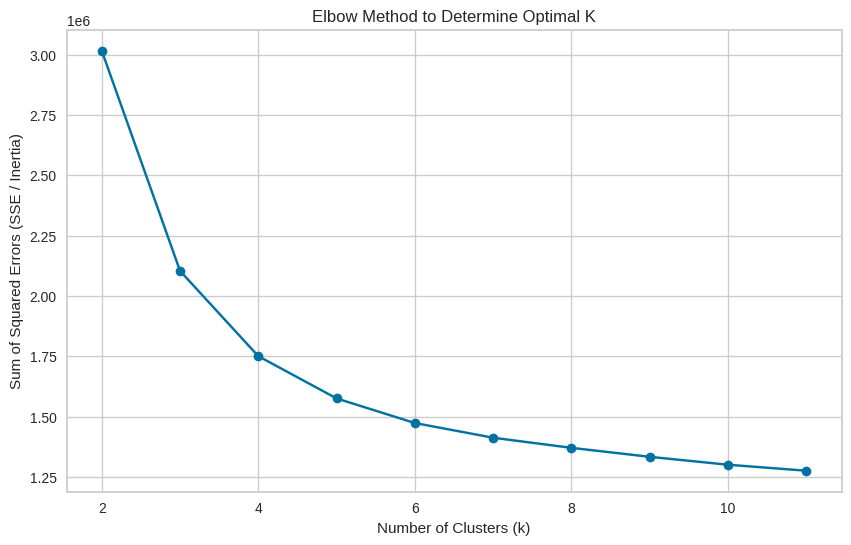

K Values and their corresponding SSE:

k=2: SSE=3015956.78

k=3: SSE=2103564.21

k=4: SSE=1750348.96

k=5: SSE=1575194.34

k=6: SSE=1473260.98

k=7: SSE=1412386.69

k=8: SSE=1370477.81

k=9: SSE=1333269.12

k=10: SSE=1300488.01

k=11: SSE=1275680.25

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(range_k, sse, marker='o', linestyle='-', color='b')
plt.title('Elbow Method to Determine Optimal K')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE / Inertia)')
plt.grid(True)
plt.show()

console.print("K Values and their corresponding SSE:")
for k, sse_val in zip(range_k, sse):
  console.print(f"k={k}: SSE={sse_val:.2f}")

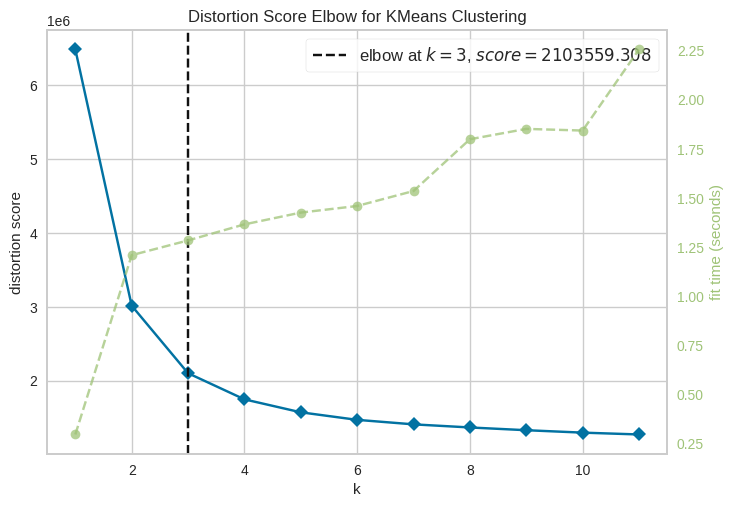

In [16]:
kmeans_temp = KMeans(init = "k-means++", random_state=42, n_init=10)
visualizer = KElbowVisualizer(kmeans_temp, k=(1,12))
visualizer.fit(df_images_pca)
visualizer.show();

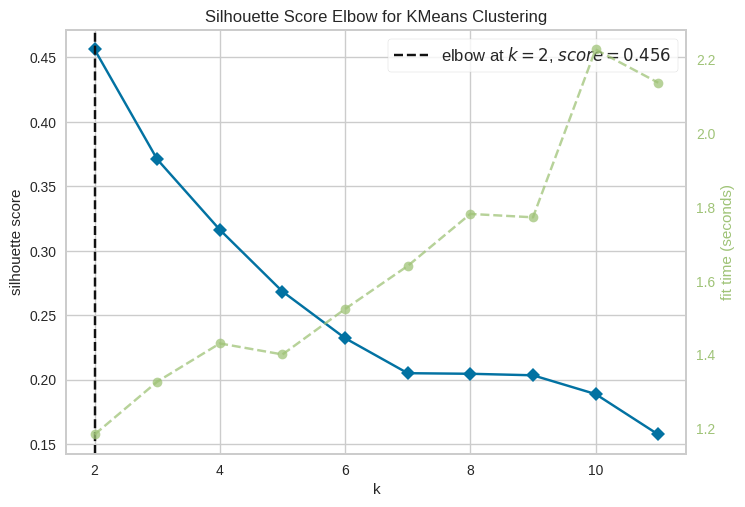

In [17]:
visualizer = KElbowVisualizer(kmeans_temp, k=(2,12), metric='silhouette')
visualizer.fit(df_images_pca)
visualizer.show();

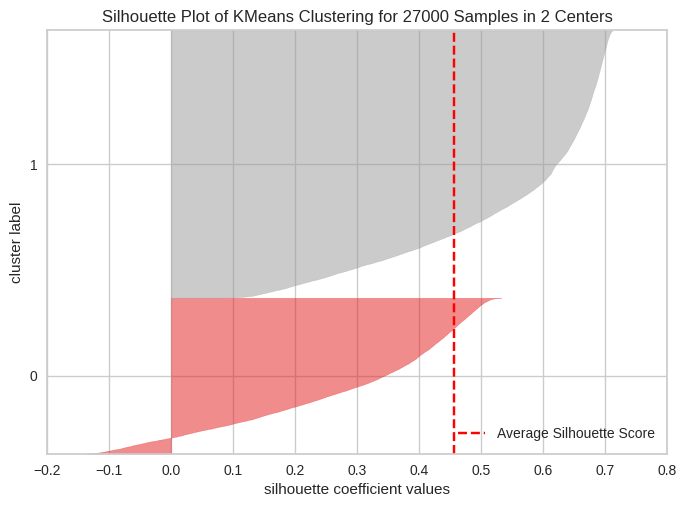

In [18]:
visualizer = silhouette_visualizer(KMeans(2, random_state=10, n_init=10), df_images_pca)

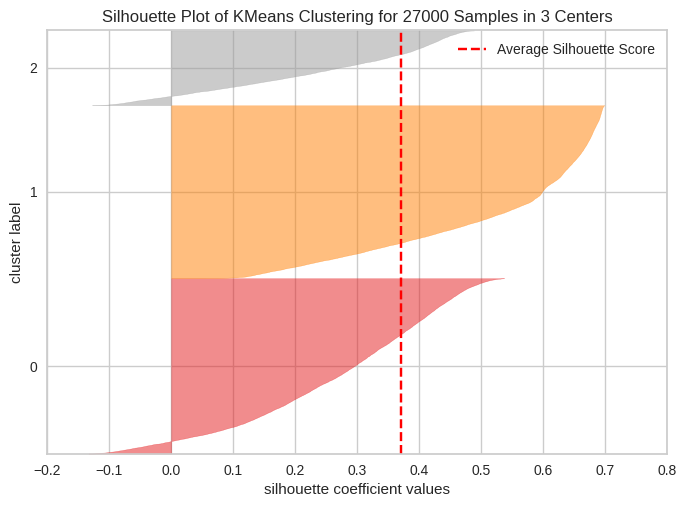

In [19]:
visualizer = silhouette_visualizer(KMeans(3, random_state=10, n_init=10), df_images_pca)

In [20]:
kmeans = KMeans(init = "k-means++", n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(df_images_pca)

### **Conclusion:**

- According to the elbow method, k=3 was chosen because the variance becomes constant beyond this point. This validates the hypothesis of dividing the terrain into three predominant visual states.

### **DBSCAN**

In [21]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 4.8 MB/s eta 0:00:00


In [22]:
scaler_pca = StandardScaler()
X_pca_whitened = scaler_pca.fit_transform(df_images_pca)

### **Calculation of DBSCAN Hyperparameters**

For the DBSCAN algorithm configuration, an automated hyperparameter search was implemented using the **Optuna framework**. Since DBSCAN is highly sensitive to the neighborhood radius and the MinSamples configuration, a Bayesian optimization strategy was chosen instead of a manual search. This allowed for an efficient exploration of the search space, adapted to the PCA dimensionality, with the goal of maximizing the silhouette coefficient and objectively finding the best possible density configuration before evaluating the final model performance.

In [23]:
import optuna
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_blobs

def objective(trial):
    """
    Objective function that Optuna will try to maximize (Silhouette score).
    """

    eps = trial.suggest_float('eps', 0.5, 3.5, log=True)
    min_samples = trial.suggest_int('min_samples', 30, 80)

    dbscan = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
    labels = dbscan.fit_predict(X_pca_whitened)

    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

    if n_clusters < 2:
        return -1.0

    noise_ratio = np.sum(labels == -1) / len(labels)
    if noise_ratio > 0.80:
      return -1.0

    try:
      score = silhouette_score(X_pca_whitened, labels, sample_size=5000, random_state=42)
    except:
      return -1.0

    return score

In [24]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200, show_progress_bar=True)

print("--- Optuna Results ---")
print(f"Best Silhouette Score: {study.best_value:.4f}")
print(f"Best Hyperparameters Found: {study.best_params}")

[I 2025-11-17 03:26:01,172] A new study created in memory with name: no-name-10877d89-ce4c-443c-a846-c5057d17978b


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2025-11-17 03:26:05,392] Trial 0 finished with value: -1.0 and parameters: {'eps': 3.127934214833318, 'min_samples': 32}. Best is trial 0 with value: -1.0.
[I 2025-11-17 03:26:06,590] Trial 1 finished with value: -1.0 and parameters: {'eps': 1.498220052615962, 'min_samples': 60}. Best is trial 0 with value: -1.0.
[I 2025-11-17 03:26:07,656] Trial 2 finished with value: -1.0 and parameters: {'eps': 0.9535919116231909, 'min_samples': 39}. Best is trial 0 with value: -1.0.
[I 2025-11-17 03:26:09,083] Trial 3 finished with value: -1.0 and parameters: {'eps': 1.73912668305465, 'min_samples': 40}. Best is trial 0 with value: -1.0.
[I 2025-11-17 03:26:13,251] Trial 4 finished with value: -1.0 and parameters: {'eps': 3.4578409792449993, 'min_samples': 41}. Best is trial 0 with value: -1.0.
[I 2025-11-17 03:26:14,243] Trial 5 finished with value: -1.0 and parameters: {'eps': 0.757978405346211, 'min_samples': 55}. Best is trial 0 with value: -1.0.
[I 2025-11-17 03:26:16,946] Trial 6 finished 

In [38]:
dbscan = DBSCAN(eps=1.2211814836381962, min_samples=68)
dbscan_labels = dbscan.fit_predict(X_pca_whitened)

In [46]:
unique_labels = set(dbscan_labels)
n_clusters = len(unique_labels) - (1 if -1 in dbscan_labels else 0)
noise_ratio = list(dbscan_labels).count(-1) / len(dbscan_labels)

console.print(f"Clusters Found: {n_clusters}")
console.print(f"Noise Ratio: {noise_ratio:.2%}")

Clusters Found: 2

Noise Ratio: 68.65%

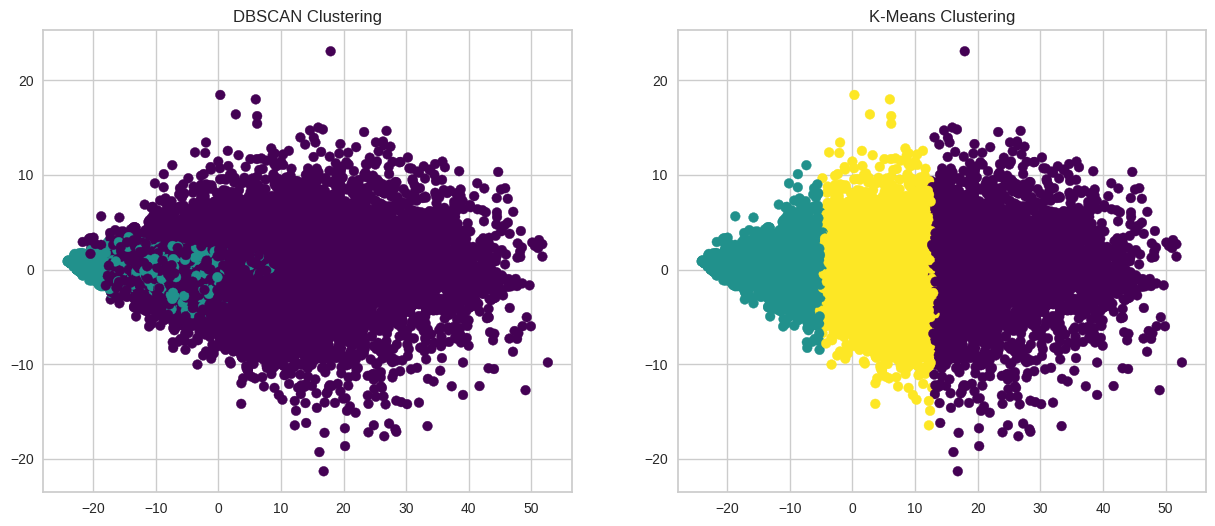

In [40]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.scatter(df_images_pca.iloc[:, 0], df_images_pca.iloc[:, 1], c=dbscan_labels, cmap='viridis')
ax1.set_title('DBSCAN Clustering')

ax2.scatter(df_images_pca.iloc[:, 0], df_images_pca.iloc[:, 1], c=kmeans_labels, cmap='viridis')
ax2.set_title('K-Means Clustering')

plt.show()

## **Gaussian Mixture**

In [28]:
n_components = np.arange(1,15)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(X_pca_whitened)
          for n in n_components]

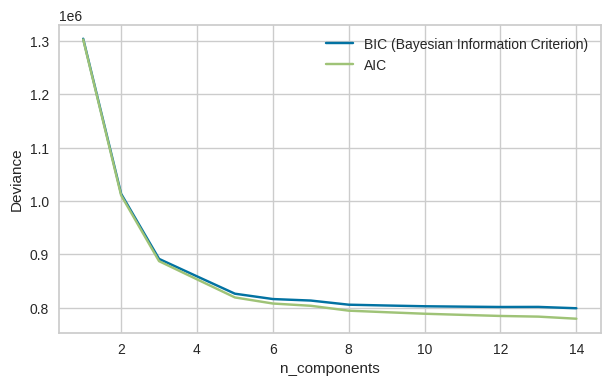

In [29]:
fig = plt.figure(figsize=(7, 4))
plt.plot(n_components, [m.bic(X_pca_whitened) for m in models], label='BIC (Bayesian Information Criterion)')
plt.plot(n_components, [m.aic(X_pca_whitened) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.ylabel('Deviance')
plt.show()

### **Conclusion:**
- We took the lowest BIC and AIC values ​​that were significant, so we chose 4, 5, and 6 to test and analyze the results.

In [30]:
best_n_components = 4
gmm = GaussianMixture(best_n_components, covariance_type='full', random_state=42)
gmm_labels = gmm.fit_predict(X_pca_whitened)
console.print(f"Labels generated: {gmm_labels.shape}")

Labels generated: (27000,)

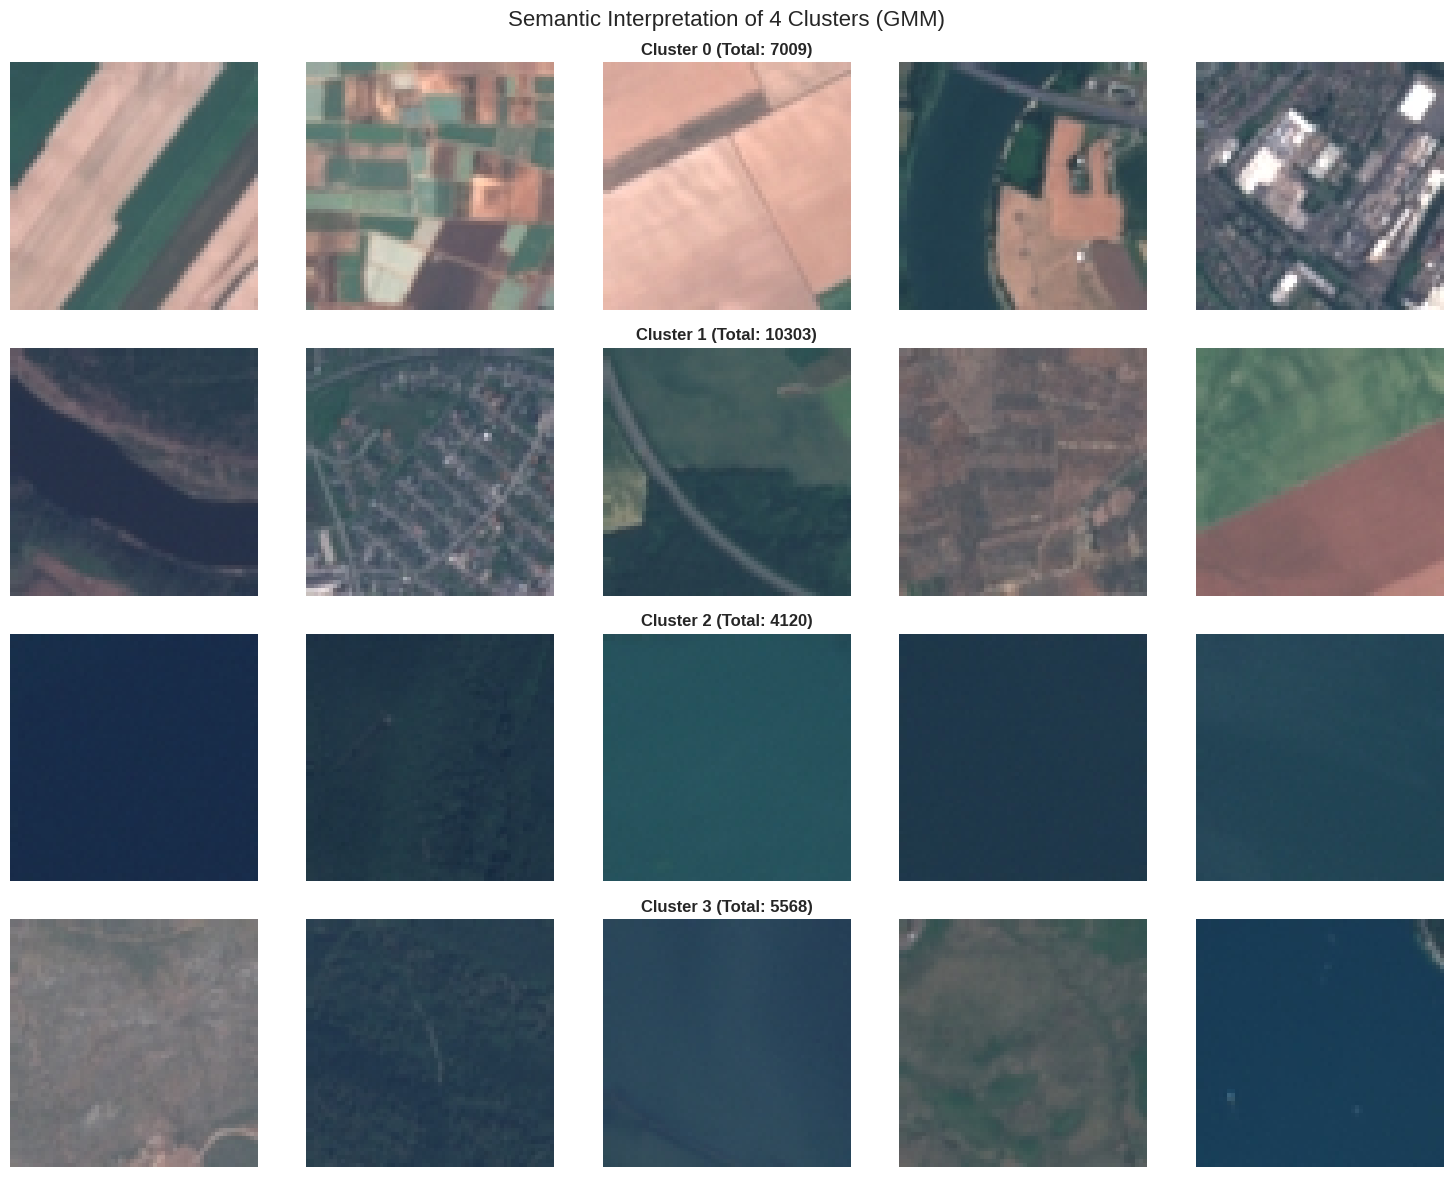

In [44]:
import matplotlib.pyplot as plt
import numpy as np

n_clusters = 4
samples_per_cluster = 5

plt.figure(figsize=(15, 12))

for k in range(n_clusters):
    cluster_indices = np.where(gmm_labels == k)[0]

    if len(cluster_indices) == 0:
        continue

    sample_indices = np.random.choice(cluster_indices, samples_per_cluster, replace=False)

    for i, idx in enumerate(sample_indices):
        plt.subplot(n_clusters, samples_per_cluster, k * samples_per_cluster + i + 1)

        #original image
        img_display = X[idx].reshape(64, 64, 3)

        plt.imshow(img_display)
        plt.axis('off')
        if i == 2:
            plt.title(f'Cluster {k} (Total: {len(cluster_indices)})', fontsize=12, fontweight='bold')

plt.suptitle(f'Semantic Interpretation of {n_clusters} Clusters (GMM)', fontsize=16)
plt.tight_layout()
plt.show()

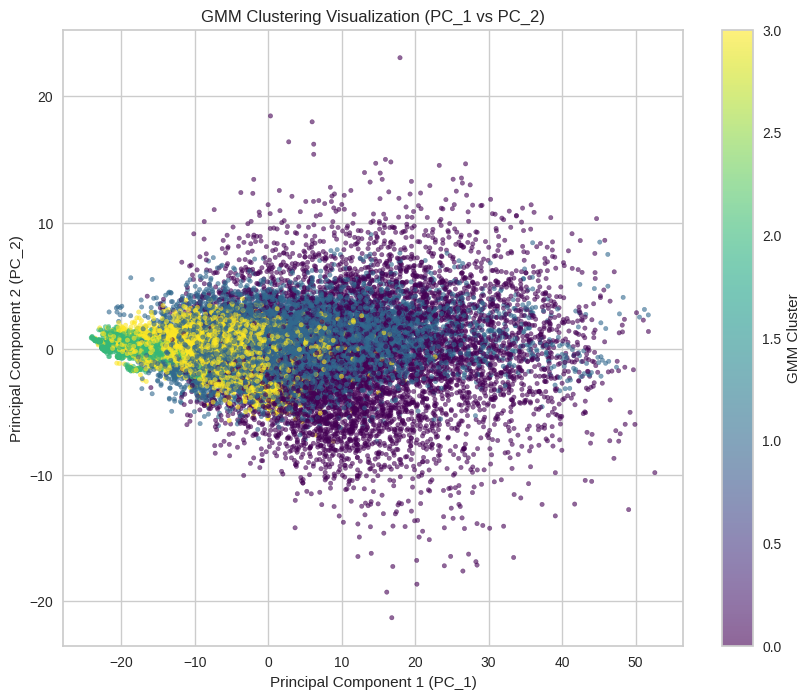

In [43]:
plt.figure(figsize=(10, 8))
plt.scatter(df_images_pca['PC_1'], df_images_pca['PC_2'], c=gmm_labels, cmap='viridis', s=10, alpha=0.6)
plt.title('GMM Clustering Visualization (PC_1 vs PC_2)')
plt.xlabel('Principal Component 1 (PC_1)')
plt.ylabel('Principal Component 2 (PC_2)')
plt.colorbar(label='GMM Cluster')
plt.grid(True)
plt.show()

## **Evaluation and profiling (The agroecological connection)**

### **Internal Validation**

The **GMM (Gaussian Mixture Models)** model outperformed previous approaches thanks to its probabilistic clustering capability. By assigning membership probabilities instead of rigid boundaries, it identified four clearly differentiated land cover typologies:

* **Group 0 (Soil/Anthropogenic):** High-reflectance areas encompassing exposed soil, industrial infrastructure, and urban areas.

* **Group 1 (Agriculture):** Mixed-textured mosaics (green/brown) typical of active crops and pastures.

* **Group 2 (Water):** Dark, homogeneous surfaces corresponding to deep water bodies.

* **Group 3 (Dense Vegetation):** Dense forest cover and well-preserved protected areas.

**Anomaly Detection Strategy:** Based on this segmentation, a state transition alert system is proposed for the agricultural agency:

* **Drought Alert:** Transition from **Group 1 (Crops)** to **Group 0 (Fertile Soil)**.

* **Flood Alert:** Transition from **Group 0 or 1** to **Group 2 (Water)**.

* **Deforestation Alert:** Transition from **Group 3 (Forests)** to **Group 0 or 1**.

In [33]:
gmm_labels[10]
console.print(len(gmm_labels))

27000

In [34]:
all_y = []
for image_y in all_images_y:
  images = image_y["images"]
  y = image_y["y"]
  for img in images:
    all_y.append(y)

console.print(f"Total Number of images: {len(all_y)}")
console.print(f"Total Number of labels: {len(gmm_labels)}")
console.print(f"Total Number of images and labels: {len(all_y) == len(gmm_labels)}")

Total Number of images: 27000

Total Number of labels: 27000

Total Number of images and labels: True

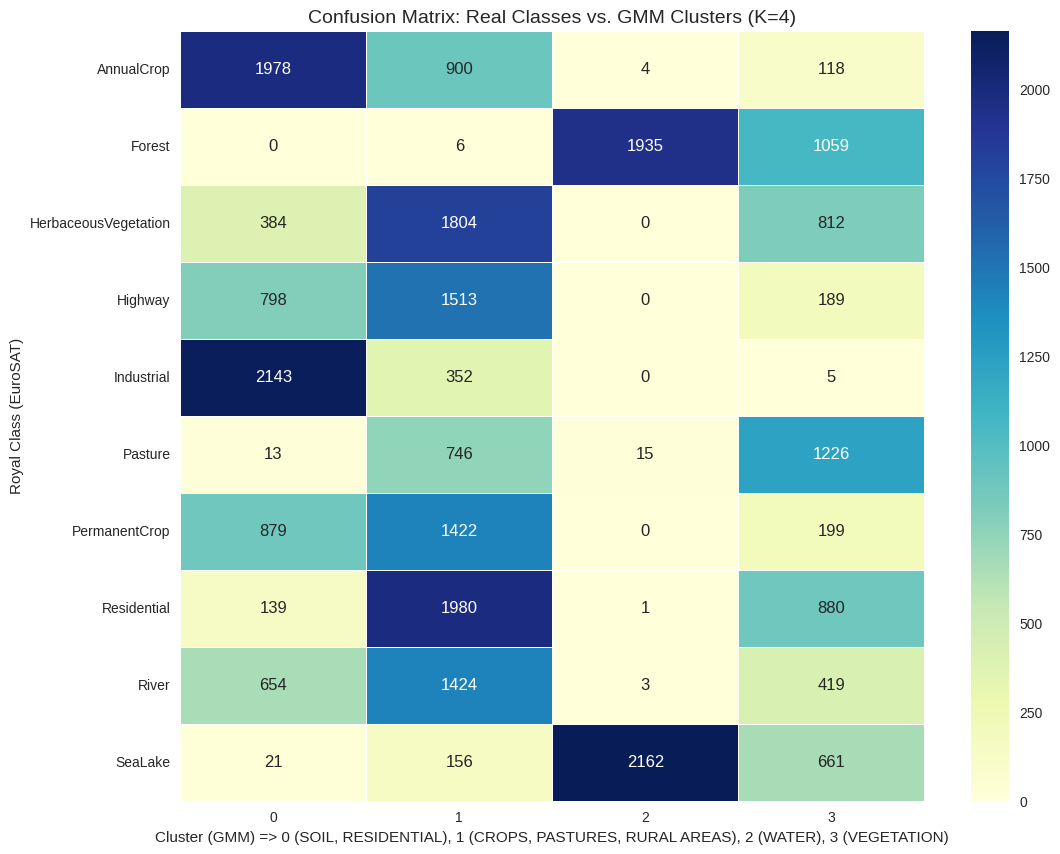

In [47]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score


eurosat_classes = {
    0: 'AnnualCrop',
    1: 'Forest',
    2: 'HerbaceousVegetation',
    3: 'Highway',
    4: 'Industrial',
    5: 'Pasture',
    6: 'PermanentCrop',
    7: 'Residential',
    8: 'River',
    9: 'SeaLake'
}

y_names = [eurosat_classes[label] if label in eurosat_classes else label for label in all_y]

df_confusion = pd.crosstab(
    pd.Series(y_names, name='Royal Class (EuroSAT)'),
    pd.Series(gmm_labels, name='Cluster (GMM) => 0 (SOIL, RESIDENTIAL), 1 (CROPS, PASTURES, RURAL AREAS), 2 (WATER), 3 (VEGETATION)')
)

plt.figure(figsize=(12, 10))
sns.heatmap(df_confusion, annot=True, fmt='d', cmap='YlGnBu', linewidths=0.5)
plt.title('Confusion Matrix: Real Classes vs. GMM Clusters (K=4)', fontsize=14)
plt.show()

In [48]:
ari = adjusted_rand_score(all_y, gmm_labels)
nmi = normalized_mutual_info_score(all_y, gmm_labels)

console.print("-" * 40)
console.print("EXTERNAL VALIDATION REPORT")
console.print("-" * 40)
console.print(f"Adjusted Rand Index (ARI):       {ari:.4f}")
console.print(f"Normalized Mutual Info (NMI):    {nmi:.4f}")
console.print("-" * 40)

----------------------------------------

EXTERNAL VALIDATION REPORT

----------------------------------------

Adjusted Rand Index (ARI):       0.1531

Normalized Mutual Info (NMI):    0.3040

----------------------------------------

In [49]:
from sklearn.metrics import v_measure_score, homogeneity_score, completeness_score
from sklearn.metrics import fowlkes_mallows_score

homogeneity = homogeneity_score(all_y, gmm_labels)
completeness = completeness_score(all_y, gmm_labels)
v_measure = v_measure_score(all_y, gmm_labels)
fmi = fowlkes_mallows_score(all_y, gmm_labels)


console.print("=" * 45)
console.print("EXTENDED EXTERNAL VALIDATION REPORT (GMM K=4)")
console.print("=" * 45)
console.print(f"Information Metrics (Structural Similarity):")
console.print(f"Normalized Mutual Information (NMI): {nmi:.4f}")
console.print(f"V Measure (H/C Balance): {v_measure:.4f}")
console.print(f"\nV Measure Breakdown:")

console.print(f"Homogeneity (Cluster Purity): {homogeneity:.4f}")

console.print(f"Completeness (Class Capture): {completeness:.4f}")

console.print("\n" + "-" * 45)

console.print(f"Pair Metrics (assignment) Similarity):")
console.print(f"Adjusted Rand Index (ARI): {ari:.4f}")
console.print(f"Fowlkes-Mallows Score (FMI): {fmi:.4f}")
console.print("=" * 45)

=============================================

EXTENDED EXTERNAL VALIDATION REPORT (GMM K=4)

=============================================

Information Metrics (Structural Similarity):

Normalized Mutual Information (NMI): 0.3040

V Measure (H/C Balance): 0.3040

V Measure Breakdown:

Homogeneity (Cluster Purity): 0.2401

Completeness (Class Capture): 0.4142

---------------------------------------------

Pair Metrics (assignment) Similarity):

Adjusted Rand Index (ARI): 0.1531

Fowlkes-Mallows Score (FMI): 0.3156

=============================================

### **External Validation Report:**

**Normalized Mutual Info (NMI):**

* This metric measures the shared information between the predicted clusters (K=4) and the actual classes (K=10). A value of 0.3040 indicates that the 4 clusters successfully capture 30.4% of the information regarding the true terrain structure.
* The problem complexity was reduced by 60% (from 10 classes to 4), yet over 30% of the fundamental information was retained. This is a highly robust result. It demonstrates that the GMM did not cluster randomly but rather identified the logical super-categories (Water, Forest, Crop, Soil/Urban) underlying the data.

**ARI (Adjusted Rand Index):**

* ARI is a highly strict metric. It severely penalizes an action the model performed intentionally: grouping different classes into the same cluster. However, given that the semantic grouping was successful, this lower score is the expected outcome for this metric.

**Completeness vs. Homogeneity:**

* **Completeness (0.41):** Indicates good performance in capturing real classes. For example, Cluster 1 (Water or very dark Forest) captures these instances effectively, while ignoring unrelated classes (observed as zeros in other cases).
* **Homogeneity (0.24):** Low (as expected). This metric reflects that the clusters are not "pure," which is a natural consequence of condensing 10 classes into 4 mixed groups.

## **Conclusions:**

**Model Selection (GMM):**

* K-Means and DBSCAN were tested but discarded. K-Means ($K=3$) resulted in an overly simplistic segmentation, and DBSCAN failed to identify a coherent density structure. The GMM model ($K=4$) was selected for its superiority in adapting to the elliptical covariance of the data, achieving a robust semantic separation into four categories:
    * **Cluster 0 (Soil/Anthropic):** High reflectance zones (bare soil, industrial, urban).
    * **Cluster 1 (Agriculture):** Mixed texture mosaics (crops, pastures).
    * **Cluster 2 (Water):** Dark homogeneous surfaces (rivers, sea).
    * **Cluster 3 (Dense Vegetation):** Dark green zones (forests).

**Model Verdict and Metrics:**

* External validation confirms the robustness of the GMM model. The Normalized Mutual Information (NMI) of 0.30 and V-Measure of 0.30 are solid metrics, indicating that the clustering retains a significant 30% of the structural information from the 10 real classes.
* The breakdown of the V-Measure is key: the high Completeness (0.41) demonstrates that the model successfully captured real classes (such as 'Water'), while the low Homogeneity (0.24) reflects the intentional fusion of semantically similar classes (e.g., 'Industrial' and 'Residential').

**Separation of Crops vs. Forests:**

* Yes, the algorithm successfully created separate clusters for crop fields and forests.
* The GMM was sensitive enough to differentiate the texture patterns of Dense Vegetation (Cluster 3) from the Agriculture mosaics (Cluster 1). This separation is fundamental for the agricultural agency's use case, enabling independent monitoring of active crop zones versus forest reserves.

**Other:**

* For the configuration of the DBSCAN algorithm, an automated hyperparameter search was implemented using the **Optuna** framework. Given that DBSCAN is highly sensitive to the configuration of $\epsilon$ (neighborhood radius) and **MinSamples**, a Bayesian optimization strategy was chosen over a manual search. This allowed for an efficient exploration of the search space adapted to the dimensionality of the PCA, with the objective of maximizing the Silhouette Coefficient and objectively finding the best possible density configuration before evaluating the final model performance.